In [20]:
import pandas as pd
import numpy as np
import random
import regex as re
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df_train = pd.read_csv('train.tsv', sep='\t')
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


Variáveis:

- name: nome do produto
- item_condition_id: condição do produto. Vai de 1 a 5, sendo 1 o produto é novo
- category_name: categoria do produto
- brand_name: nome da marca
- price: preço do produto
- shipping: taxa de envio, 1 se foi paga pelo vendedor e 0 se foi pelo comprador
- item_description: descrição do produto

In [6]:
print('Shape treino:',df_train.shape)

Shape treino: (1482535, 8)


In [360]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


Variáveis de categoria e nome do produto possuem valores missing:

In [7]:
df_train.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

## Análise Exploratória

**Price**

A distribuição dos preços é assimétrica a direita. A maioria dos itens possuem preços baixos. 

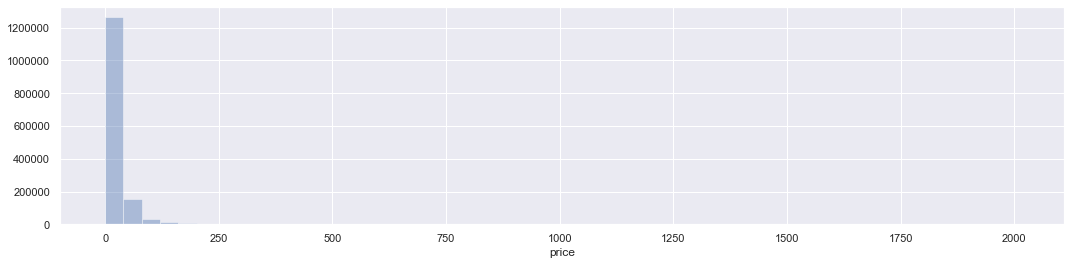

In [8]:
sns.set(rc={'figure.figsize':(18, 4)})
sns.distplot(df_train.price,kde=False)

Aplicando a transformação logarítimica, vemos que a distribuição dos preços agora se assemelha a uma distribuição normal.

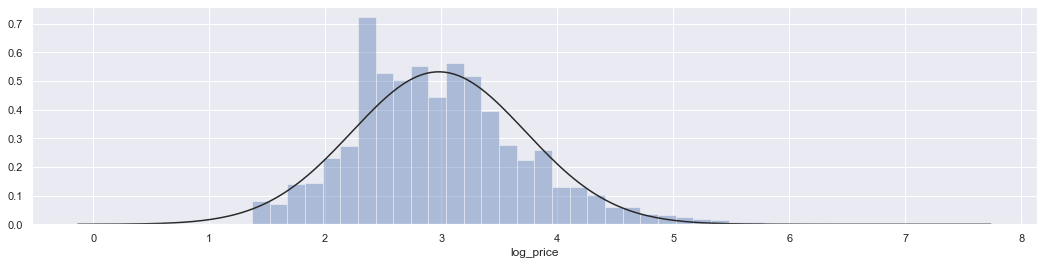

In [9]:
df_train['log_price']=np.log1p(df_train.price)

sns.distplot(df_train.log_price, fit=norm, kde=False)

**item_condition_id**

A maioria dos itens vendidos são novos e em boas condiçoes

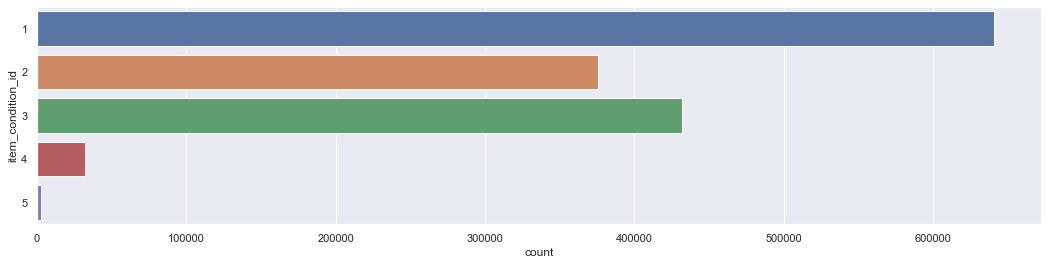

In [10]:
fig = sns.countplot(data=df_train, y = 'item_condition_id')

(0, 50)

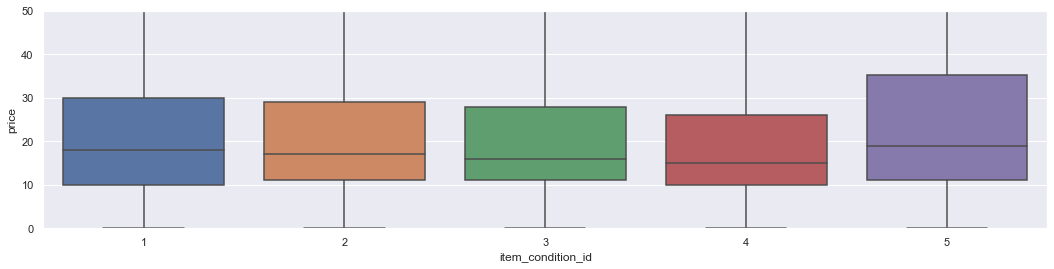

In [11]:
ax=sns.boxplot(df_train.item_condition_id, df_train.price)
ax.set_ylim([0,50])

**shipping**

A taxa de remessa é frequentemente paga pelo vendedor, mas a frequência que os compradores pagam é alta também.

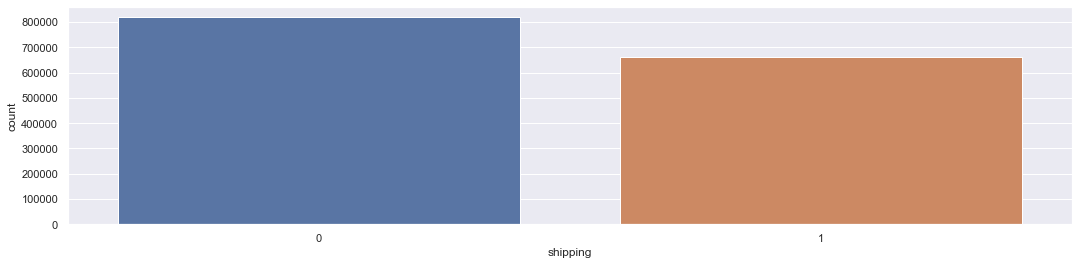

In [12]:
fig = sns.countplot(data=df_train, x='shipping')

(0, 100)

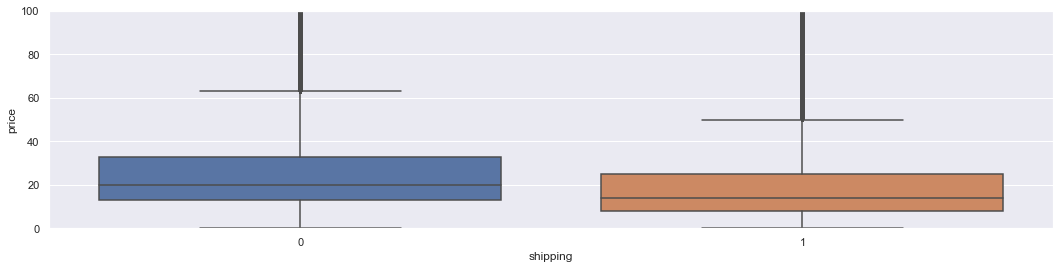

In [13]:
ax=sns.boxplot(df_train.shipping, df_train.price )
ax.set_ylim([0,100])

**brand_name**

O preço das marcas mais frequentes são baixos e próximos entre si. O box-plot retratou novamente a característica assimétrica a direita do preço e sendo uma variável com muitos outliers reafirma o uso da transformação logarítmica.

(0, 100)

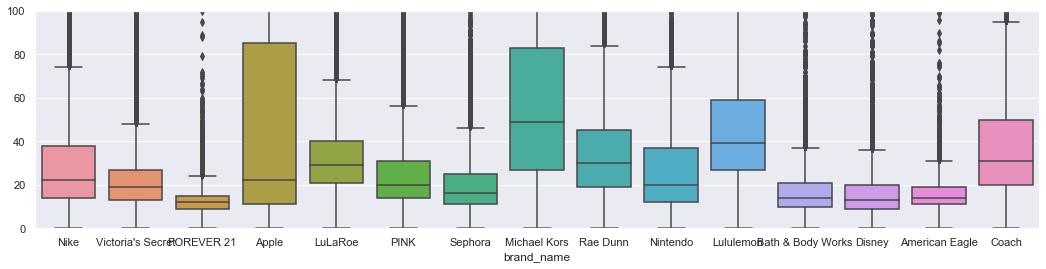

In [14]:
filtro = df_train.brand_name.value_counts().index.values.astype('str')[:15]

x = df_train[df_train.brand_name.isin(filtro)]['brand_name']
y = df_train[df_train.brand_name.isin(filtro)]['price'].values
ax = sns.boxplot(x, y)
ax.set_ylim([0, 100])   

In [15]:
print("Existem %d marcas únicas na base de treino:" % df_train['brand_name'].nunique())

Existem 4809 marcas únicas na base de treino:


In [16]:
#Top 50 das marcas
df_train.groupby(['brand_name']).size().sort_values(ascending=False)[:50]

brand_name
PINK                   54088
Nike                   54043
Victoria's Secret      48036
LuLaRoe                31024
Apple                  17322
FOREVER 21             15186
Nintendo               15007
Lululemon              14558
Michael Kors           13928
American Eagle         13254
Rae Dunn               12305
Sephora                12172
Coach                  10463
Disney                 10360
Bath & Body Works      10354
Adidas                 10202
Funko                   9237
Under Armour            8461
Sony                    7994
Old Navy                7567
Hollister               6948
Carter's                6385
Urban Decay             6210
The North Face          6172
Independent             5902
Too Faced               5794
Xbox                    5709
Brandy Melville         5680
Kate Spade              5411
MAC                     5302
Kendra Scott            5097
Gap                     5088
Tarte                   4984
UGG Australia           4676
VAN

**item_description**

A grande maioria dos itens não tem descrição e termos parecidos se repetem com frequência.

In [17]:
df_train.groupby(['item_description']).size().sort_values(ascending=False)[:20]

item_description
No description yet     82489
New                     4099
Brand new               3058
Good condition          1274
Great condition         1158
Like new                 987
Never worn               837
NWT                      822
New with tags            644
Never used               605
Excellent condition      604
Worn once                582
Brand new with tags      518
Size small               453
Brand new!               447
New in box               442
BNWT                     435
Brand New                424
Bundle                   401
Brand new.               389
dtype: int64

Por ser um campo com dados não estruturados e de difícil tratamento, foi criado duas variáveis a partir de seu dados. 

- description_length: Tamanho da descrição, tirando acento e pontuações.
- description_boolean: Tem o valor 0 se possuir a categoria 'No description yet' e 1 caso contrário

A função abaixo transforma o texto em *lower case*, retira *stopwords*, pontuações e números. Buscando deixar apenas as palavras relevantes do texto.

In [26]:
# ref https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

stop_words = nltk.corpus.stopwords.words('english')

def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        
        filter_ = 'no description yet'
        txt = str(np.where(txt == filter_, ' ', txt))
  
        words = [w for w in txt.split(" ") \
                 if not w in stop_words and not w in (' ')]
        return len(words)
    except: 
        return 0

Criação da variável description_length:

In [27]:
df_train['description_length'] = df_train['item_description'].apply(lambda x: wordCount(x))

Box-plot do tamanho da descrição em relação ao preço:

(0, 60)

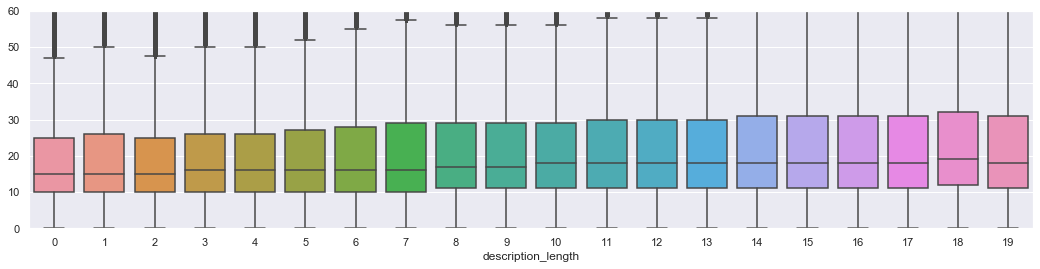

In [28]:
filtro=df_train.description_length.value_counts().index.values.astype('str')[:20]

x=df_train[df_train.description_length.isin(filtro)]['description_length']
y=df_train[df_train.description_length.isin(filtro)]['price'].values

ax=sns.boxplot(x,y)
ax.set_ylim([0,60])

Criação da variável description_boolean:

In [29]:
filtro = df_train['item_description'].value_counts().index.values.astype('str')[0]
df_train['description_boolean']=np.where(df_train['item_description']==filtro,0,1)

df_train.groupby(['description_boolean']).size()

description_boolean
0      82489
1    1400046
dtype: int64

(0, 70)

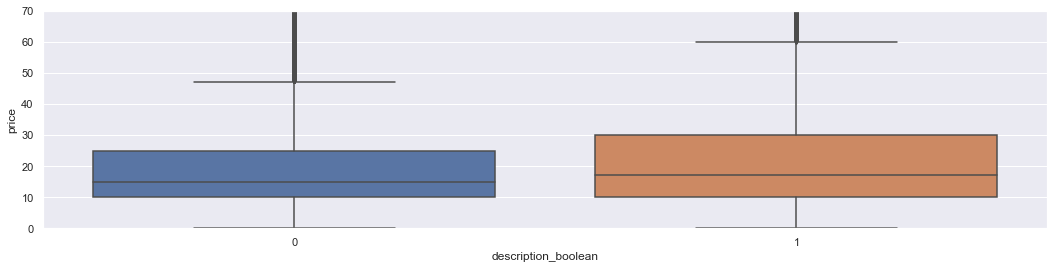

In [30]:
#Distribuiçao em relacao aos preços
ax=sns.boxplot(df_train.description_boolean, df_train.price)
ax.set_ylim([0, 70])  

**category_name**

In [32]:
df_train.groupby(['category_name']).size().sort_values(ascending=False)[:20]

category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Women/Dresses/Above Knee, Mini                                 20082
Women/Jewelry/Necklaces                                        19758
Women/Athletic Apparel/Shorts                                  19528
Beauty/Makeup/Makeup Palettes                                  19103
Women/Shoes/Boots   

A grande maioria dos itens são descritos em 3 categorias. Dessa forma, iremos criar 3 variáveis a partir da decomposição da 'category_name'.

In [33]:
qt_1categ = df_train[df_train.category_name.str.count('/')==0].shape[0]
qt_2categ = df_train[df_train.category_name.str.count('/')==1].shape[0]
qt_3categ = df_train[df_train.category_name.str.count('/')==2].shape[0]
qt_dif2_categ = df_train[df_train.category_name.str.count('/')!=2].shape[0]

print('Produtos com 1 categoria:', qt_1categ)
print('Produtos com 2 categoria:', qt_2categ)
print('Produtos com 3 categorias:', qt_3categ)
print('Produtos com mais que 2 categorias:', qt_dif2_categ)

Produtos com 1 categoria: 0
Produtos com 2 categoria: 0
Produtos com 3 categorias: 1471819
Produtos com mais que 2 categorias: 10716


In [34]:
def transform_split_category_name(df):
    category_split = df['category_name'].str.split(r'/', n=2, expand=True)
    for i in [0,1,2]:
        df['cat_level_' + str(i)] = category_split[i]
    return df

df_train=transform_split_category_name(df_train)
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,description_length,description_boolean,cat_level_0,cat_level_1,cat_level_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,0,0,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,18,1,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,14,1,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,18,1,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,3,1,Women,Jewelry,Necklaces


Quais as marcas mais comuns da categoria Electronics?

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Brand')]

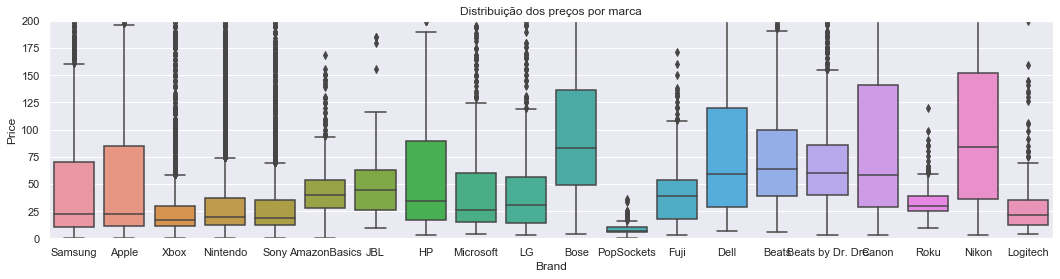

In [35]:
filtro = df_train[df_train['cat_level_0'] == 'Electronics'].brand_name.value_counts().index.values.astype('str')[:20]

x = df_train[df_train.brand_name.isin(filtro)]['brand_name']
y = df_train[df_train.brand_name.isin(filtro)]['price'].values


ax = sns.boxplot(x, y)
ax.set_ylim([0, 200])   
plt.title('Distribuição dos preços por marca')
ax.set(xlabel='Brand', ylabel='Price')

Supondo que o nível 0 é a categoria principal, vemos que existem 10 categorias e que a de maior frequência é a de 'women'

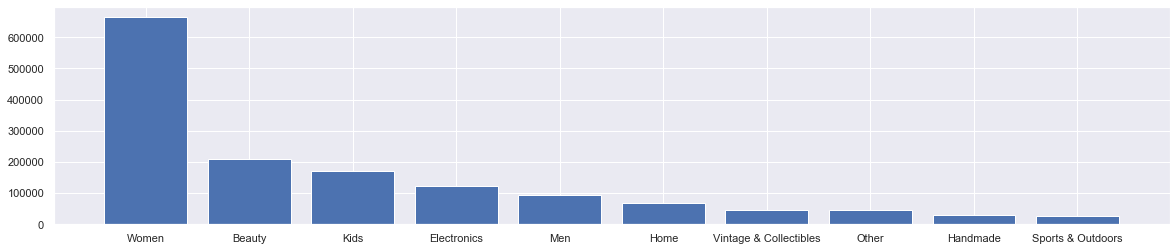

In [36]:
x = df_train['cat_level_0'].value_counts().index.values.astype('str')
y = df_train['cat_level_0'].value_counts().values

sns.set(rc={'figure.figsize':(20, 4)})
plt.bar(x,y)
plt.show()

Top 10 categorias do nível 2:

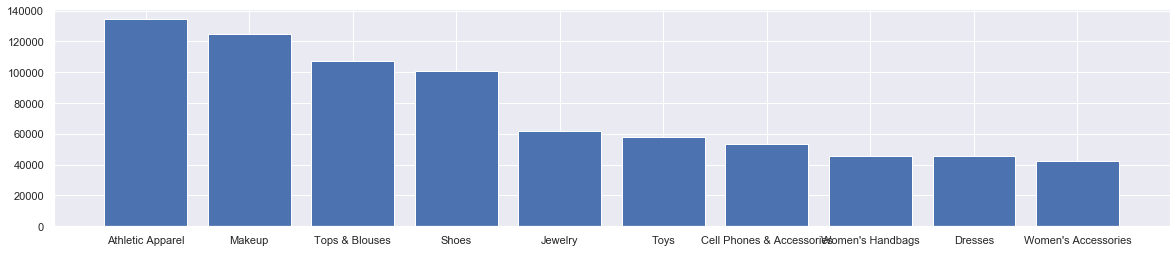

In [37]:
x = df_train['cat_level_1'].value_counts().index.values.astype('str')[:10]
y = df_train['cat_level_1'].value_counts().values[:10]

sns.set(rc={'figure.figsize':(20, 4)})
plt.bar(x,y)
plt.show()

Top 10 categorias nível 3

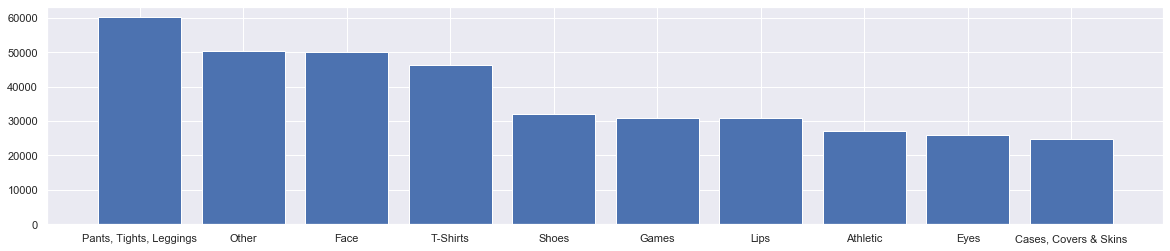

In [38]:
x = df_train['cat_level_2'].value_counts().index.values.astype('str')[:10]
y = df_train['cat_level_2'].value_counts().values[:10]

sns.set(rc={'figure.figsize':(20, 4)})
plt.bar(x,y)
plt.show()

Vendo aque a grande maioria dos itens estão do top 10 do nível de categoria 1, 2 e 3, vamos substituir as demais categorias pela palavra 'others'.

Faremos o mesmo processo para a variável brand, porém pegando o top 50.

In [39]:
train = df_train

#cat_level_0
x_cat_level_0=train['cat_level_0'].value_counts().index.values.astype('str')[:10]
train.loc[~train.cat_level_0.isin(x_cat_level_0),'cat_level_0'] = "others"


#cat_level_1l
x_cat_level_1=train['cat_level_1'].value_counts().index.values.astype('str')[:10]
train.loc[~train.cat_level_1.isin(x_cat_level_1),'cat_level_1'] = "others"

#cat_level_2
x_cat_level_2=train['cat_level_2'].value_counts().index.values.astype('str')[:10]
train.loc[~train.cat_level_2.isin(x_cat_level_2),'cat_level_2'] = 'others'

x_brand = train['brand_name'].value_counts().index.values.astype('str')[:50]
train.loc[~train.brand_name.isin(x_brand),'brand_name'] = 'others_brand'

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,description_length,description_boolean,cat_level_0,cat_level_1,cat_level_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,others_brand,10.0,1,No description yet,2.397895,0,0,Men,others,others
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,others_brand,52.0,0,This keyboard is in great condition and works ...,3.970292,18,1,Electronics,others,others
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,others_brand,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,14,1,Women,Tops & Blouses,others
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,others_brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,18,1,Home,others,others
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,others_brand,44.0,0,Complete with certificate of authenticity,3.806662,3,1,Women,Jewelry,others


## Modelagem

In [40]:
train = pd.get_dummies(data=train, columns=['item_condition_id','cat_level_0','cat_level_1','cat_level_2','brand_name'], 
                       prefix=['condition_id',"Cat_0",'Cat_1','Cat_2','brand'] )

Filtrar as colunas que serão usadas na modelagem:

In [41]:
not_colunas = ['train_id','price','log_price','name','category_name','brand_name','item_description','item_condition_id']
X_train = train.loc[:, ~train.columns.isin(not_colunas)]
y_train =  train.log_price

print('Shape preditoras treino:', X_train.shape)
print('Shape resposta treino:', y_train.shape)


Shape preditoras treino: (1482535, 92)
Shape resposta treino: (1482535,)


In [42]:
X_train.head(5)

,shipping,description_length,description_boolean,condition_id_1,condition_id_2,condition_id_3,condition_id_4,condition_id_5,Cat_0_Beauty,Cat_0_Electronics,...,brand_Too Faced,brand_Tory Burch,brand_UGG Australia,brand_Under Armour,brand_Urban Decay,brand_VANS,brand_Vera Bradley,brand_Victoria's Secret,brand_Xbox,brand_others_brand
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,18,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,14,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,18,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Dividir em treino e teste. Sendo 20% para teste e 80% para treino.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

**Lightgbm**

In [46]:
X_train_dataset = lgb.Dataset(X_train, label=y_train)

In [47]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

gbm = lgb.train(params, train_set=X_train_dataset, num_boost_round=3200, verbose_eval=100)

predictions_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Métricas de validação:

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_lgbm))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_lgbm))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_lgbm)))
print('R2:',metrics.r2_score(y_test, predictions_lgbm))

Mean Absolute Error: 0.46774865413677386
Mean Squared Error: 0.37722639586680057
Root Mean Squared Error: 0.6141875901276421
R2: 0.3232812111195118
